In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm # for all the arima related stuff as well as the data that we want to train the models with

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel as C
from importlib import reload

import myArimaModelWrapper


# configure pyplot such that it looks nice and is easy to use
%matplotlib inline 
plt.style.use('seaborn-colorblind')

## Load the data

In [2]:
# Load dataset that contains data about sun activity for the years 1700 to 2008.
# Each datum contains data for the year and the corresponding sunactivity index.
df = sm.datasets.sunspots.load_pandas().data

# The data is structured such that we have a separate column for the date. 
# Instead, we want to have a time series object with the date as index. 
# For that, we have to convert the year (which is a float) to a string of format YYYY.
df['year_datetime'] = pd.to_datetime(df['YEAR'].astype(str), format='%Y.0', errors='coerce')
df = df.set_index('year_datetime')

# Resample the data such that we have one datum per year
df = df.resample('y').mean()

# Make sure that we do not have missing values, fill them with the previous value
df = df.fillna(df.bfill())

# split data into training and validation
training_data = df[:'1970']
validation_data = df['1971':]

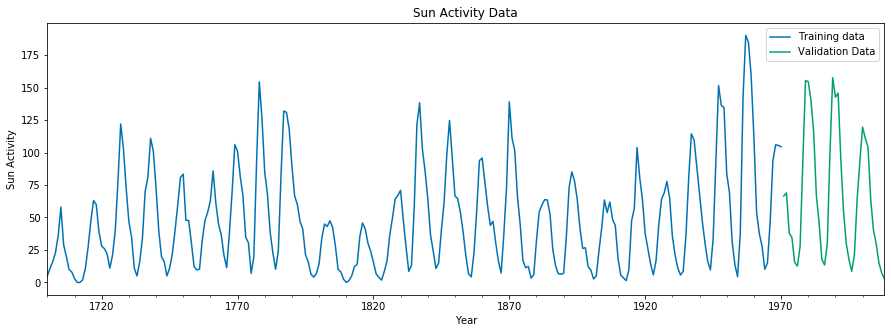

In [3]:
ax = training_data['SUNACTIVITY'].plot(title='Sun Activity Data', figsize=(15, 5))
validation_data['SUNACTIVITY'].plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.legend(['Training data', 'Validation Data'])
#ax.get_legend().remove()
plt.show()

## Prepare the training and validation data for the ARIMA and the GP model

In [4]:
def extract_data_for_specific_labels(data, *labels):
    valid_labels = [label for label in labels if label in data]
    return data[valid_labels].to_numpy().reshape(-1, len(valid_labels))

training_data_gp = {'x': extract_data_for_specific_labels(training_data, 'YEAR'), 
                    'y': extract_data_for_specific_labels(training_data, 'SUNACTIVITY')}
validation_data_gp = {'x': extract_data_for_specific_labels(validation_data, 'YEAR'), 
                      'y': extract_data_for_specific_labels(validation_data, 'SUNACTIVITY')}

training_data_arima = training_data['SUNACTIVITY']
validation_data_arima = validation_data['SUNACTIVITY']

## Set up and train the ARIMA model
Note that we use a simple brute force method by simply testing a lot of different model parameters. 
Also note, that although we should not use AIC as criterion amongst models with different d values, we get the best model if we use this criterion.

In [5]:
reload(myArimaModelWrapper)
model = myArimaModelWrapper.ArimaModelWrapper(training_data_arima)
model.train(pmax=2, dmax=3, qmax=2, s=11, criterion='aic')

ARIMA(0, 0, 0)x(0, 0, 0, 11), aic:2989.798038661468
ARIMA(0, 0, 0)x(0, 0, 1, 11), aic:2696.105694449896
ARIMA(0, 0, 0)x(0, 1, 0, 11), aic:2549.6556351218396
ARIMA(0, 0, 0)x(0, 1, 1, 11), aic:2440.0927943951747
ARIMA(0, 0, 0)x(0, 2, 0, 11), aic:2646.0204220967835
ARIMA(0, 0, 0)x(0, 2, 1, 11), aic:2374.005268813241
ARIMA(0, 0, 0)x(1, 0, 0, 11), aic:2547.6029970129143
ARIMA(0, 0, 0)x(1, 0, 1, 11), aic:2539.179902893227
ARIMA(0, 0, 0)x(1, 1, 0, 11), aic:2453.043702775618
ARIMA(0, 0, 0)x(1, 1, 1, 11), aic:2416.626691143852
ARIMA(0, 0, 0)x(1, 2, 0, 11), aic:2482.512773933392
ARIMA(0, 0, 0)x(1, 2, 1, 11), aic:2373.0696940956
ARIMA(0, 0, 1)x(0, 0, 0, 11), aic:2689.9097409581705
ARIMA(0, 0, 1)x(0, 0, 1, 11), aic:2463.9859941771438
ARIMA(0, 0, 1)x(0, 1, 0, 11), aic:2361.532876486646
ARIMA(0, 0, 1)x(0, 1, 1, 11), aic:2243.5422162895647
ARIMA(0, 0, 1)x(0, 2, 0, 11), aic:2484.2515912446916
ARIMA(0, 0, 1)x(0, 2, 1, 11), aic:2201.009253803277
ARIMA(0, 0, 1)x(1, 0, 0, 11), aic:2360.290979710253
ARIMA(

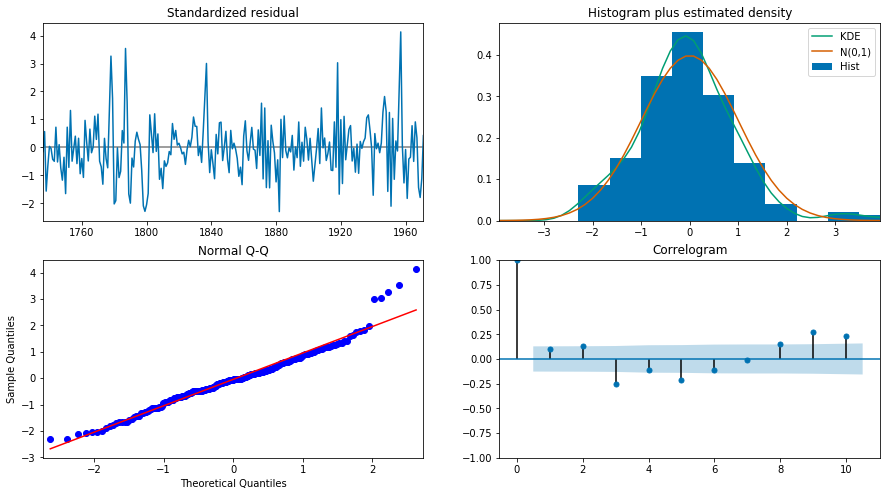

In [6]:
model.plot_diagnostics()

## Get forecasts from the ARIMA model 

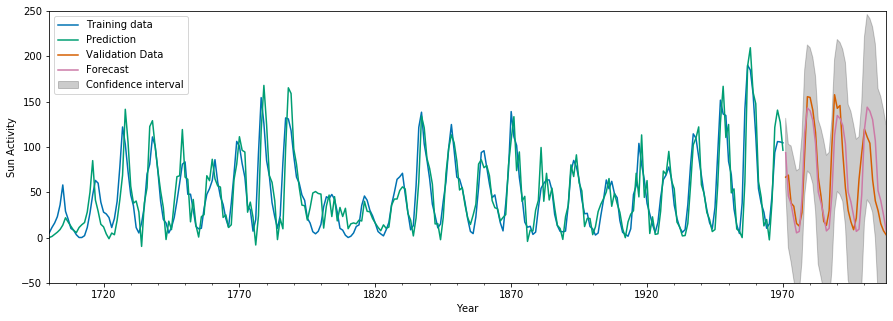

In [11]:
train_pred_mean, train_pred_ci = model.predict(start='1700-12-31', end='1970-12-31', dynamic=False)
validation_pred_mean, validation_pred_ci = model.predict(start='1971-12-31', end='2008-12-31')

ax = training_data_arima.plot(label='Training data', figsize=(15,5))
train_pred_mean.plot(ax=ax, label='Prediction')
validation_data_arima.plot(ax=ax, label='Validation data')
validation_pred_mean.plot(ax=ax, label='Forecast')
ax.fill_between(validation_pred_ci.index, validation_pred_ci.iloc[:, 0], validation_pred_ci.iloc[:, 1], label='Confidence interval', color='k', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.legend(['Training data', 'Prediction', 'Validation Data', 'Forecast', 'Confidence interval'])
plt.xlim('1700-12-31', '2008-12-31')
plt.ylim(-50, 250)
plt.show()


## Set up and train the Gaussian process model

In [8]:
# Our kernel consists of:
# a part reflecting long-range trends, 
# plus two terms for seasonal effects (with the amplitudes changing once faster and once slower), 
# plus a noise term.  
kernel_trend_long_range = C(1) * RBF(length_scale=1e2, length_scale_bounds=(1e1, 1e3))
kernel_seasonal_slowly_changing_amplitude = C(10) * RBF(length_scale=1e2, length_scale_bounds=(1e2, 1e4)) \
    * ExpSineSquared(length_scale=1e0, length_scale_bounds=(1e-1, 1e1), periodicity=11, periodicity_bounds=(10, 12))
kernel_seasonal_quickly_changing_amplitude = C(1) * RBF(length_scale=1e2, length_scale_bounds=(1e0, 1e2)) \
    * ExpSineSquared(length_scale=1e0, length_scale_bounds=(1e-1, 1e1), periodicity=11, periodicity_bounds=(10, 12))
kernel = kernel_trend_long_range + kernel_seasonal_slowly_changing_amplitude + kernel_seasonal_quickly_changing_amplitude
kernel += WhiteKernel(noise_level=1)

gp = GaussianProcessRegressor(
    kernel=kernel, 
    alpha=1e-10, 
    optimizer='fmin_l_bfgs_b', 
    n_restarts_optimizer=3, # run the training multiple times to avoid local minima 
    normalize_y=True # normalize so that we tend to the mean instead of zero far away from the data 
)
gp.fit(training_data_gp['x'], training_data_gp['y'])
gp.kernel_

0.0547**2 * RBF(length_scale=613) + 16.4**2 * RBF(length_scale=272) * ExpSineSquared(length_scale=0.923, periodicity=11.2) + 33.9**2 * RBF(length_scale=8.46) * ExpSineSquared(length_scale=1.21, periodicity=10.4) + WhiteKernel(noise_level=31.9)

## Get forecasts from the GP model

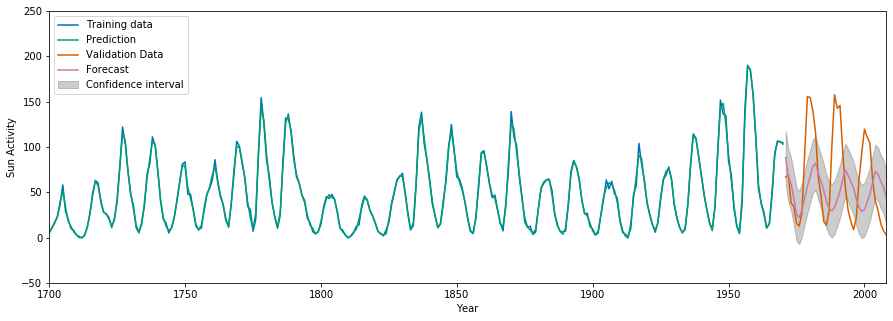

In [10]:
# Calculate prediction including mean and confidence interval.
# In order to have a confidence interval of 95%, we take 2 * sigma, this is just slightly above 95%
training_data_gp['pred'] = gp.predict(training_data_gp['x'], return_std=False)
validation_data_gp['pred'], validation_data_gp['std'] = gp.predict(validation_data_gp['x'], return_std=True)
validation_data_gp['ci_lo'] = validation_data_gp['pred'] - 2*validation_data_gp['std']
validation_data_gp['ci_up'] = validation_data_gp['pred'] + 2*validation_data_gp['std']

plt.figure(figsize=(15, 5))
plt.plot(training_data_gp['x'], training_data_gp['y'])
plt.plot(training_data_gp['x'], training_data_gp['pred'])
plt.plot(validation_data_gp['x'], validation_data_gp['y'])
plt.plot(validation_data_gp['x'], validation_data_gp['pred'])
plt.fill_between(validation_data_gp['x'][:,0], validation_data_gp['ci_lo'][:,0], validation_data_gp['ci_up'][:,0],
                 alpha=0.2, color='k');
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.legend(['Training data', 'Prediction', 'Validation Data', 'Forecast', 'Confidence interval'])
plt.xlim(1700, 2008)
plt.ylim(-50, 250)
plt.show()
